# Определение стоимости автомобилей 

"Не бит, не крашен" - сервис по продаже автомобилей, в котором разрабатывается приложение для клиентов. Это приложение позволит узнать стоимость приобретаемого автомобиля. 

**Целью** нашего проекта будет создание эффективной **модели**, которая позволит делать **предсказания стоимости** представленных авто на основе ее входных характеристик. 

Исходные данные будут содержать следующие характеристики:

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя
- **Price** - цена

В ходе разработки и создания нашей модели, мы будем опираться на такие важные характеристики, как **качество предсказания, время обучения модели, время предсказания модели**. 

Строить наше исследование будем следующим образом - изучим исходные данные, обработаем пропуски, дубликаты, аномалии, несоответствующие типы данных. Проверим данные на взаимосвязанность - определим корреляцию между различными характеристиками. Это позволит определить наличие избыточных данных и исключить их из дальнейшей работы. Так же определим характеристики, которые не влияют не предсказание *стоимости* автомобиля. 

Далее мы подготовим данные для обучения - разделим их на соответствующие выборки. 

В качестве моделей обучения воспользуемся **LightGBM и случайный лес**. Для каждой из моделей будем подбирать различные гиперпараметры. 

Из рассмотренных моделей выберем наиболее качественную и протестируем ее на тестовой выборке. Затем проведем анализ адекватности выбранной модели, подведем соответсвующие итоги. 

In [1]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
from sklearn.metrics import ( mean_absolute_error, fbeta_score, make_scorer, mean_squared_error )
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import time
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# 1. Предобработка данных

Считаем имеющиеся данные в соответсвующий датафрейм. 

In [2]:
try:
    data= pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')  

Выведем общую информацию о данных 

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод**: из представленного видно, что в некоторых переменных следует провести замену типа данных. 

*DateCrawled, DateCreated и LastSeen* необходимо заменить на тип datetime. 

In [5]:
data['DateCrawled'] = pd.to_datetime(
    data['DateCrawled'], format='%Y-%m-%dT%H:%M:%S'
)
data['DateCreated'] = pd.to_datetime(
    data['DateCreated'], format='%Y-%m-%dT%H:%M:%S'
)
data['LastSeen'] = pd.to_datetime(
    data['LastSeen'], format='%Y-%m-%dT%H:%M:%S'
)

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проверим данные на дубликаты 

In [7]:
print(data.duplicated().sum())

4


**Вывод**: в данных присутствует 4 дублированных значения, необходимо удалить подобные случаи. 

In [8]:
#Удаляем дублирующиеся значения
data = data.drop_duplicates()
print(data.duplicated().sum())

0


In [9]:
print('Пропуски в data', data.isna().sum())

Пропуски в data DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


**Вывод**: в данных присутствует большое количество пропусков в таких характеристиках как VehicleType, Gearbox, Model, FuelType и Repaired. 

Изучим каждый из типов пропущенных значения. 

Text(0, 0.5, 'Количество')

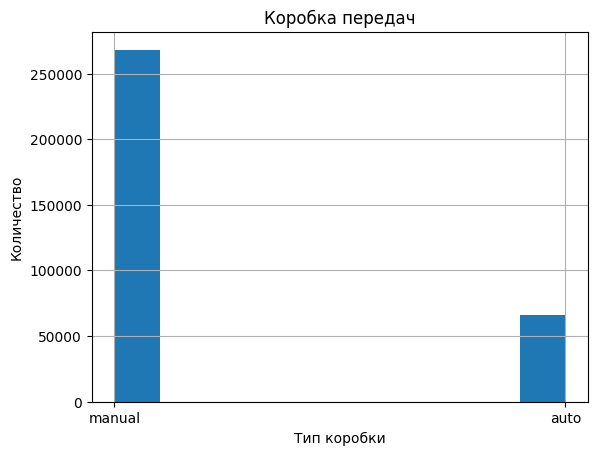

In [10]:
#Рассмотрим тип коробки передач
data['Gearbox'].hist()
plt.title('Коробка передач')
plt.xlabel('Тип коробки')
plt.ylabel('Количество')

Количество пропущенных значений по типу коробки передач составляет:

In [11]:
data['Gearbox'].isna().sum()

19833

Процентное соотношение пропущенных значений от общего числа 

In [12]:
data['Gearbox'].isna().sum()/data['Gearbox'].count() * 100

5.928580823359201

**Вывод**: пропущенных значений по типу коробки передач в наших данных - порядка 6 процентов. Заменим пропущенные значения на unknown для дальшейшей возможности построения модели.  

Text(0, 0.5, 'Количество')

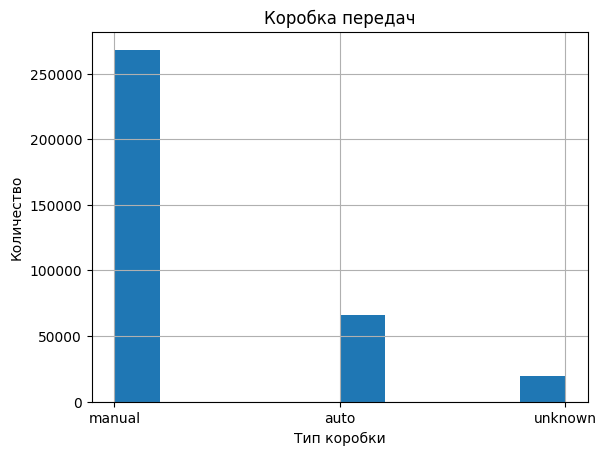

In [13]:
#Заменим пропущеные значения по типу коробки передач на тип unknown
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Gearbox'].hist()
plt.title('Коробка передач')
plt.xlabel('Тип коробки')
plt.ylabel('Количество')

Рассмотрим теперь тип моделей. 

In [14]:
data['Model'].unique()


array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Поступим таким же образом, заменим пропущенные значения моделей на метку unknown

In [15]:
data['Model'] = data['Model'].fillna('unknown')

In [16]:
data['Model'].isna().sum()

0

Характеристика VehicleType.

Text(0, 0.5, 'Количество')

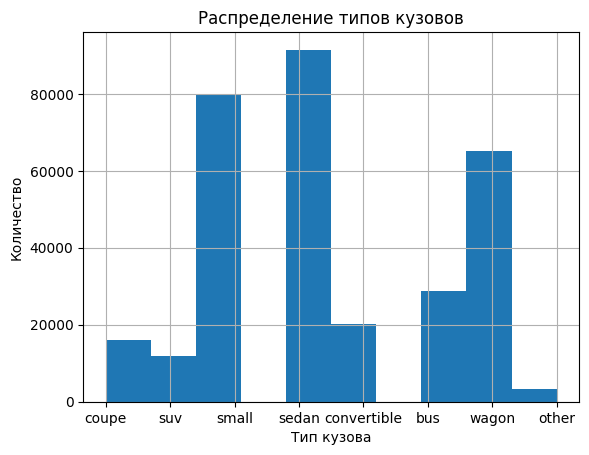

In [17]:
data['VehicleType'].hist()
plt.title('Распределение типов кузовов')
plt.xlabel('Тип кузова')
plt.ylabel('Количество')

Пропущенных значений по признаку VehicleType значительное количество - 37490. Удалить их из выборки, мы не можем, поэтому поместим неизвестные значения в столбец other.

In [18]:
data['VehicleType'] = data['VehicleType'].fillna('other')

Рассмотрим теперь типы топлива.

Text(0, 0.5, 'Количество')

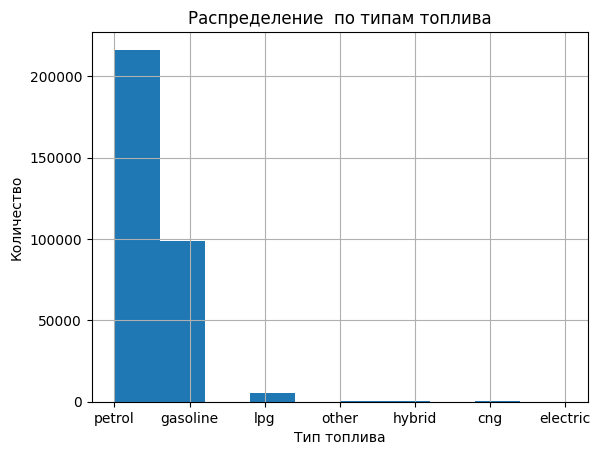

In [19]:
data['FuelType'].hist()
plt.title('Распределение  по типам топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Количество')

Можно заметить, что petrol и gasoline - английский и американский термины для бензина. Логичным будет объединение этих типов в один. 

In [20]:
data['FuelType'] = data['FuelType'].str.replace('gasoline','petrol')

Пропущенные значения в этом случае также можно поместить в столбец other.

In [21]:
data['FuelType']=data['FuelType'].fillna('other')

И последний из пропущенных параметров - наличие ремонта. 

Text(0, 0.5, 'Количество')

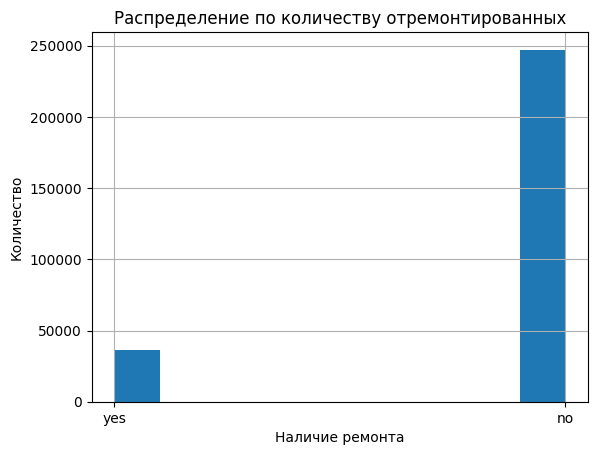

In [22]:
data['Repaired'].hist()
plt.title('Распределение по количеству отремонтированных')
plt.xlabel('Наличие ремонта')
plt.ylabel('Количество')

Поскольку этот параметр, также представляет важность, а востановить данные не получается возможным - укажем это напрямую, с помощью маркера N/A.

In [23]:
data['Repaired']=data['Repaired'].fillna('N/A')

In [24]:
print('Пропуски в data', data.isna().sum())

Пропуски в data DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


**Вывод**: при предварительном изучении данных было обнаружено, что у части данных, которые отвечают за временные величины, будет оптимально сменить имеющиеся типы данных на datetime. Обнаруженные дублированные значения были удалены, а пропущенные значения обработаны. Для характеристик Gearbox и Model отсутсвующие данные были удалены. Для других таких параметров подобная же процедура удалила бы значительный процент имеющихся данных, поэтому пропущенные значения были  заменены либо на тип other, либо на N/A. 

Построим гистограммы для целочисленных переменных. 

**Цена**

Text(0, 0.5, 'Frequency')

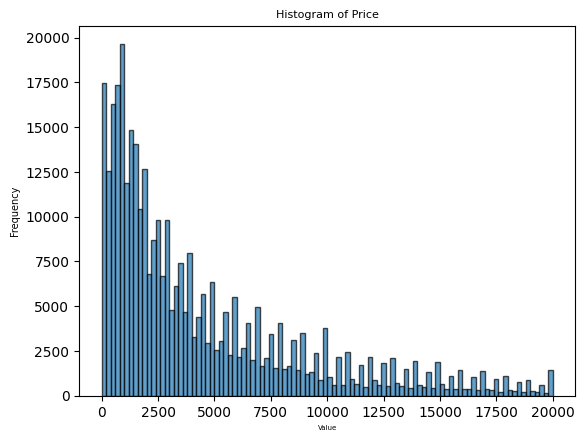

In [25]:
data['Price'].plot.hist(bins = 100, alpha=0.7, edgecolor='black')
plt.title(f'Histogram of Price', fontsize=8)
plt.xlabel('Value', fontsize=5)
plt.ylabel('Frequency', fontsize=7)

<AxesSubplot:>

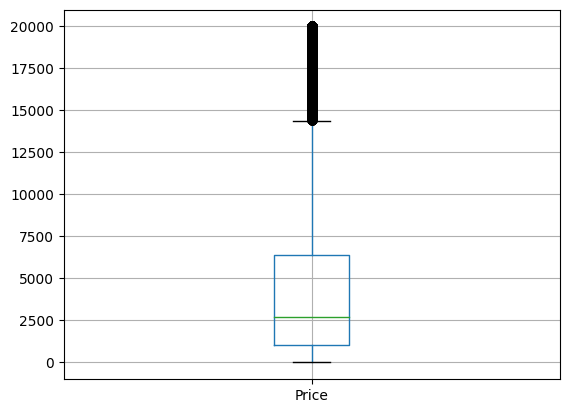

In [26]:
data.boxplot(column = 'Price')

In [27]:
pd.Series(data['Price'].unique()).sort_values(ascending=True)


7           0
51          1
459         2
354         3
1999        4
        ...  
615     19995
1901    19997
2159    19998
564     19999
442     20000
Length: 3731, dtype: int64

**Вывод**: часть значений достаточно мала, для того чтобы представлять собой цену автомобиля. Удалим значения меньше 50 евро. 

In [28]:
data = data.query('Price> 50')

**Год регистрации**

Text(0, 0.5, 'Frequency')

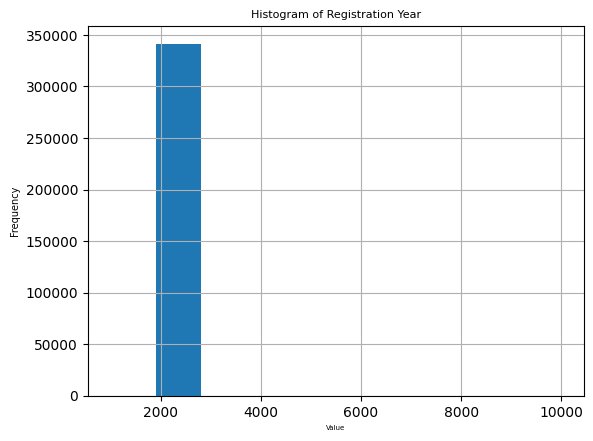

In [29]:
data['RegistrationYear'].hist()
plt.title(f'Histogram of Registration Year', fontsize=8)
plt.xlabel('Value', fontsize=5)
plt.ylabel('Frequency', fontsize=7)

<AxesSubplot:>

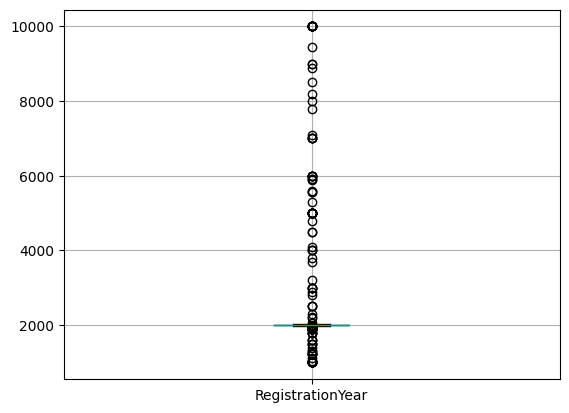

In [30]:
data.boxplot(column='RegistrationYear')


(1975.0, 2020.0)

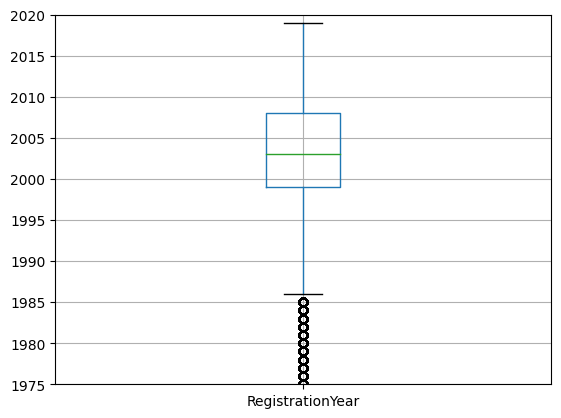

In [31]:
data.boxplot(column='RegistrationYear').set_ylim([1975, 2020])

**Вывод**: в годе регистрации наблюдаются аномально высокие и аномально низкие значения. Выберем из представленных только осмысленный промежуток 1975 - 2020

In [32]:
data = data.query('RegistrationYear > 1975')
data = data.query('RegistrationYear <= 2016')

**Power**

<AxesSubplot:>

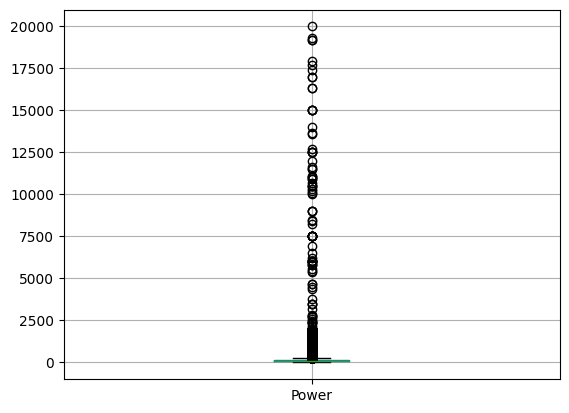

In [33]:
data.boxplot(column='Power')

(0.0, 500.0)

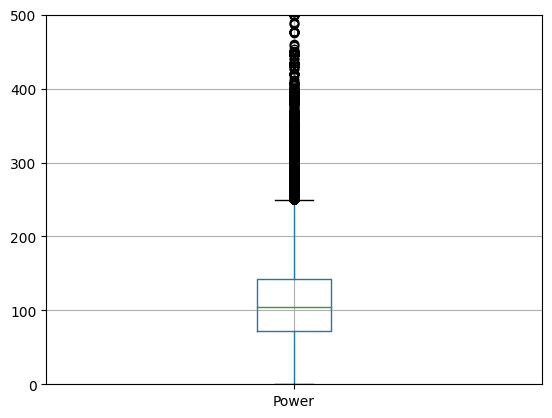

In [34]:
data.boxplot(column='Power').set_ylim([0, 500])

**Вывод**: в характеристиках **Power** также достаточно много значений, выбивающихся за межквартильный размах и имеющих физические не осмысленные значения. 

In [35]:
data = data.query('Power > 15')
data = data.query('Power < 1600')

**Number of Pictures**

<AxesSubplot:>

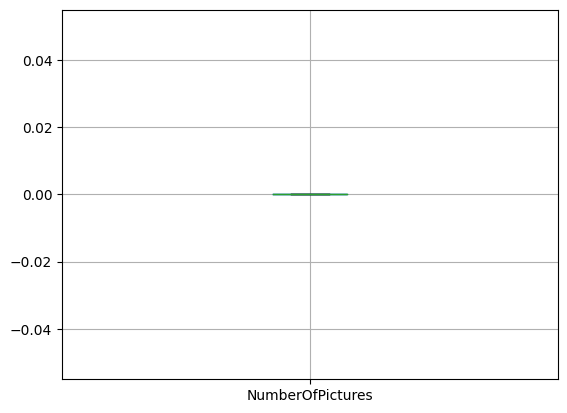

In [36]:
data.boxplot(column='NumberOfPictures')

(0.0, 1.0)

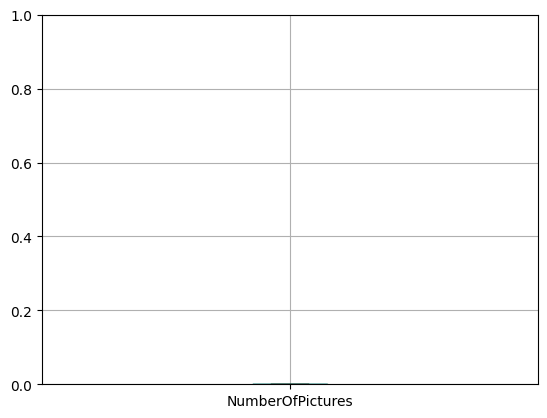

In [37]:
data.boxplot(column='NumberOfPictures').set_ylim([0, 1])

**Вывод**: все значения NumberOfPictures равны 0 и не несут информативной нагрузки, необходимой для нашей модели. 

In [38]:
data=data.drop(['NumberOfPictures'], axis=1)

**Kilometer**

Text(0, 0.5, 'частота')

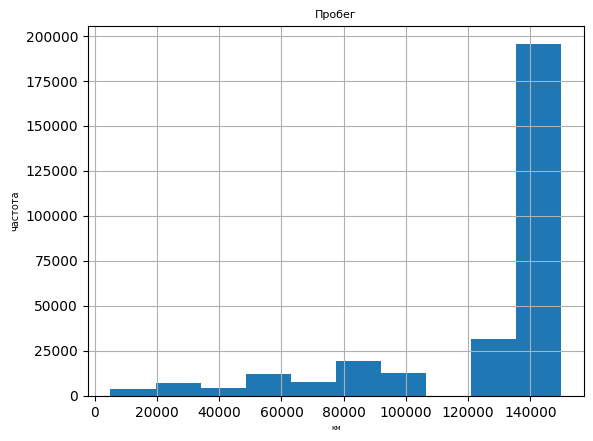

In [39]:
data['Kilometer'].hist()
plt.title(f'Пробег', fontsize=8)
plt.xlabel('км', fontsize=5)
plt.ylabel('частота', fontsize=7)

In [40]:
data['Kilometer'].describe()

count    294052.000000
mean     128538.523799
std       36496.968802
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

<AxesSubplot:>

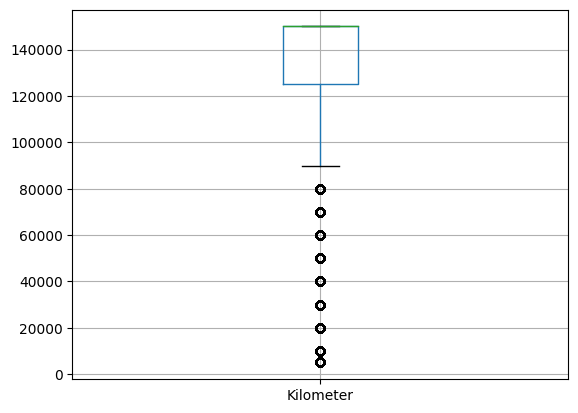

In [41]:
data.boxplot(column='Kilometer')

In [42]:
data['Kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000], dtype=int64)

**Вывод**: особых аномалий в значении пробегов не обнаружено. Но отметим, что этот признак принимает всего 13 значений, а значит его можно воспринимать, как категориальный. 

Определим возможные корреляции между признаками. 

In [43]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
Price,1.000000,0.552465,0.464095,-0.389078,0.069212,0.064165
RegistrationYear,0.552465,1.000000,0.122025,-0.351727,0.042482,0.032038
Power,0.464095,0.122025,1.000000,0.090838,0.036302,0.047316
Kilometer,-0.389078,-0.351727,0.090838,1.000000,-0.017044,-0.010354
RegistrationMonth,0.069212,0.042482,0.036302,-0.017044,1.000000,0.002197
PostalCode,0.064165,0.032038,0.047316,-0.010354,0.002197,1.000000


**Вывод**: Заметной корреляции между численными признаками не выявлено.

**Вывод**: целочисленные значения были проанализированы и обработаны. Убраны аномальные и не имеющие смысла значения. Таким образом, предобработанные данные могут далее обрабатываться для построения модели обучения. 

# 2. Подготовка модели обучения

Для дальнейшего обучения модели требуется сформировать тренировочную и тестовую выборки, а также закодировать категориальные значения. 

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294052 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        294052 non-null  datetime64[ns]
 1   Price              294052 non-null  int64         
 2   VehicleType        294052 non-null  object        
 3   RegistrationYear   294052 non-null  int64         
 4   Gearbox            294052 non-null  object        
 5   Power              294052 non-null  int64         
 6   Model              294052 non-null  object        
 7   Kilometer          294052 non-null  int64         
 8   RegistrationMonth  294052 non-null  int64         
 9   FuelType           294052 non-null  object        
 10  Brand              294052 non-null  object        
 11  Repaired           294052 non-null  object        
 12  DateCreated        294052 non-null  datetime64[ns]
 13  PostalCode         294052 non-null  int64   

Отберем только значения, которые могут влиять на ценообразование. 

In [45]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth'], axis = 1)
data=data.reset_index(drop=True)

Отберем только категориальные значения. 

In [46]:
category_columns=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired']

Отделим целевой признак от остальных. 

In [47]:
features=data.drop(['Price'],axis=1)
target=data['Price']

In [48]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
1,suv,2004,auto,163,grand,125000,petrol,jeep,N/A
2,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,small,2008,manual,69,fabia,90000,petrol,skoda,no
4,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Закодируем категориальные признаки.

In [49]:
encoder = OrdinalEncoder()
encoder.fit(features[category_columns])
features_ord=features.copy()
features_ord[category_columns]= pd.DataFrame(encoder.transform(features[category_columns]), columns = features[category_columns].columns)

In [50]:
features_ord.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,2.0,2011,1.0,190,227.0,125000,5.0,1.0,2.0
1,6.0,2004,0.0,163,117.0,125000,5.0,14.0,0.0
2,5.0,2001,1.0,75,116.0,150000,5.0,38.0,1.0
3,5.0,2008,1.0,69,101.0,90000,5.0,31.0,1.0
4,4.0,1995,1.0,102,11.0,150000,5.0,2.0,2.0


Разделим теперь исходную выборку на тестовую и тренировочную в соотношении 1:4.

In [51]:
train_features, test_features, train_target, test_target = train_test_split(features_ord, target, test_size=0.25, random_state=254)

Применим масштабирование к данным. 

In [52]:
numeric=['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','Repaired']
#Проведем масштабирование данных
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_ord[numeric]) 
train_features[numeric] = scaler.transform(train_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])
train_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
262935,1.326511,-1.825576,0.421756,-0.091472,-1.262762,0.588035,0.239993,-1.472068,-1.950785
130287,-0.108607,-0.498436,0.421756,-0.346826,-0.124914,0.588035,0.239993,-0.799305,-1.950785
50788,-0.108607,-0.000758,0.421756,0.334118,-1.495815,0.588035,0.239993,-1.546819,0.095957
106678,-1.065353,-0.996113,0.421756,-0.534086,1.437914,0.588035,0.239993,0.247214,0.095957
14613,1.326511,-0.166650,0.421756,0.317094,1.643549,0.588035,-12.418360,1.368485,0.095957


**Вывод**: из исходных данных выделены целевые признаки и обычные, категориальные признаки приведены в числовую форму, все признаки таким образом масштабированы, и в итоге они разделены на тестовую и тренировочную выборки.

# 3. Построение модели обучения 

## 3.1 Градиентный бустинг

Обучим и исследуем модель CatBoostRegressor. Модель градиентного бустинга в данном случае хорошо подходит, так как работает с неоднородными данными.

In [65]:
#Создадим функцию оценки по mean_squared_error
def rmse(prediction, target):
    return (mean_squared_error(target,prediction)**0.5).round(2)
scorer = make_scorer(rmse, greater_is_better=False)

In [67]:
prediction = [1, 2, 3]
target = [1,1,2]
rmse(prediction, target)

0.82

Определим наилучшую модель посредством кросс-валидации.

In [68]:
model = CatBoostRegressor(verbose = 0)
grid = {
         'n_estimators': [800, 900, 1000]
         }
gsearch = GridSearchCV(estimator=model, 
                       cv=5, 
                       param_grid=grid,  
                       scoring = scorer)
gsearch.fit(train_features, train_target)


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001945A46A1C0>,
             param_grid={'n_estimators': [800, 900, 1000]},
             scoring=make_scorer(rmse, greater_is_better=False))

Лучший гиперпараметр n_estimators таким образом

In [69]:
gsearch.best_params_

{'n_estimators': 1000}

C лучшим результатом

In [70]:
gsearch.best_score_

-1571.908

Исследуем время обучения нашей модели

In [58]:
%%time
start = time.time()
model_boost = CatBoostRegressor(random_state=12345,learning_rate=0.4, verbose=100,n_estimators=1000)
model_boost.fit(train_features, train_target)
end = time.time()
t_boost=round(end-start,2)

0:	learn: 3470.1308039	total: 28.3ms	remaining: 28.2s
100:	learn: 1606.2145166	total: 1.35s	remaining: 12s
200:	learn: 1532.2895497	total: 2.86s	remaining: 11.4s
300:	learn: 1487.7362663	total: 4.2s	remaining: 9.76s
400:	learn: 1454.5028222	total: 5.57s	remaining: 8.32s
500:	learn: 1430.4247006	total: 6.87s	remaining: 6.85s
600:	learn: 1410.6421683	total: 8.54s	remaining: 5.67s
700:	learn: 1393.9634606	total: 9.93s	remaining: 4.24s
800:	learn: 1379.1539764	total: 11.2s	remaining: 2.79s
900:	learn: 1366.3224248	total: 12.5s	remaining: 1.37s
999:	learn: 1355.3582534	total: 14.1s	remaining: 0us
CPU times: total: 2min 21s
Wall time: 14.3 s


Исследуем время предсказания модели 

In [59]:
%%time
start = time.time()
predict_boost=model_boost.predict(test_features)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: total: 172 ms
Wall time: 25.9 ms


**Вывод**: модель обучения CatBoostRegressor дает следующие параметры по обучению и предсказанию, 14.3 с и 25.9 мс соответственно. 


## 3.2 Случайный лес

Рассмотрим теперь более стандартную модель - модель случайного леса. 

In [60]:
model = RandomForestRegressor()
grid = {
         'n_estimators': [100, 200, 300],
          'max_depth': [6, 9]
         }
gsearch = GridSearchCV(estimator=model, 
                       cv=5, 
                       param_grid=grid,  
                       scoring=scorer)
gsearch.fit(train_features, train_target)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [6, 9], 'n_estimators': [100, 200, 300]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [61]:
gsearch.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [74]:
gsearch.best_score_

-1571.908

Измерим время обучения подобранной модели.

In [63]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345,max_depth=9, n_estimators=200)
model_rf.fit(train_features, train_target)
end = time.time()
t_rf=round(end-start,2)

CPU times: total: 45.8 s
Wall time: 45.8 s


Измерим время предсказания подбранной модели.

In [64]:
%%time
start = time.time()
pred_rf=model_rf.predict(test_features)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: total: 1.09 s
Wall time: 1.09 s


**Вывод**: модель случайного леса дает следующие параметры по обучению и предсказанию, 45.8 и 1.09 с соответственно. 

**Вывод**: видно, что модель градиентного бустинга обучается и предсказывает гораздо быстрее, чем модель случайного леса. А по параметрам качества отличаются незначительно. Поэтому разумным будет сделать выбор в пользу модели градиентного бустинга. 

# 4. Тестирование и проверка на адекватность

Проведем тестирование выбранной модели градиентного бустинга. 

In [72]:
#Расчитаем результат метрики RMSE для модели градиентного бустинга 
rmse(predict_boost, test_target)

1527.34

Сравним полученный результат с константной моделью среднего значения. 

In [73]:
#Cоздадим константную модель со средним значением
model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(train_features, train_target)
predictions_dummy = model_dummy.predict(test_features)
rmse_dummy=(mean_squared_error(test_target,predictions_dummy)**0.5).round(2)
rmse_dummy

4600.52

**Вывод**: по параметру RMSE константная модель сильно хуже рассмотренных раннее. Таким образом подобранные модели являются адекватными. 

# Вывод

При предварительном изучении данных было обнаружено, что у части данных, которые отвечают за временные величины, будет оптимально сменить имеющиеся типы данных на datetime. Обнаруженные дублированные значения были удалены, а пропущенные значения обработаны. Для характеристик Gearbox и Model отсутсвующие данные были удалены. Для других таких параметров подобная же процедура удалила бы значительный процент имеющихся данных, поэтому пропущенные значения были  заменены либо на тип other, либо на N/A. Целочисленные значения были проанализированы и обработаны. Убраны аномальные и не имеющие смысла значения. Таким образом, предобработанные данные могут далее обрабатываться для построения модели обучения. 

В ходе подготовки данных к построению моделей из исходных данных выделены целевые признаки и обычные, категориальные признаки приведены в числовую форму, все признаки таким образом масштабированы, и в итоге они разделены на тестовую и тренировочную выборки.

Были сформированы две модели - модель градиентного бустинга и модель случайного леса. По интересующим заказчика параметрам была выбрана модель градиентного бустинга со следующими параметрами. 

**Градиентный бустинг**
- время обучения 14.3 s
- время предсказания 25.9 ms
- параметр качества RMSE 1527

Таким образом, учитывая что градиентый бустинг работает на порядки быстрее, чем стандартная модель случайного леса, а по параметрам качества различия не значительны, то предпочтительной будет модель градиентного бустинга. 